# Movie Industry Analysis (TMDB 5000 Movie Dataset)

## 1. Download the sources from kaggle
The next line create a folder if doesn't exists in your root project and download the dataset for the analysis.

In [117]:
!mkdir -p datasets && curl -L -o datasets/tmdb-movie-metadata.zip https://www.kaggle.com/api/v1/datasets/download/tmdb/tmdb-movie-metadata && unzip -o datasets/tmdb-movie-metadata.zip -d datasets

15278.96s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 9099k  100 9099k    0     0  4952k      0  0:00:01  0:00:01 --:--:-- 7770kk
Archive:  datasets/tmdb-movie-metadata.zip
  inflating: datasets/tmdb_5000_credits.csv  
  inflating: datasets/tmdb_5000_movies.csv  


## 2. Importing the necessary libraries

In [118]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import ast
from sklearn.linear_model import LinearRegression
import numpy as np


# 3. Read the data and show the first columns

In [119]:
# Reading the dataset and saving it into a variable
dataset_path = 'datasets/tmdb_5000_movies.csv'
movies_df = pd.read_csv(dataset_path)
print(movies_df.head().to_markdown())

|    |    budget | genres                                                                                                                                 | homepage                                     |     id | keywords                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    | original_language   | 

First, it's important to analyze the columns, datatypes and Non-Null values in the dataset.

In [120]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

# 4. Understanding Initial Data Distribution
Understanding initial data distribution is crucial to detect missing values, outliers, and biases. It guides feature transformations, method selection, and ensures models align with data patterns, improving accuracy and fairness. Additionally, it provides key domain insights and helps communicate findings effectively.

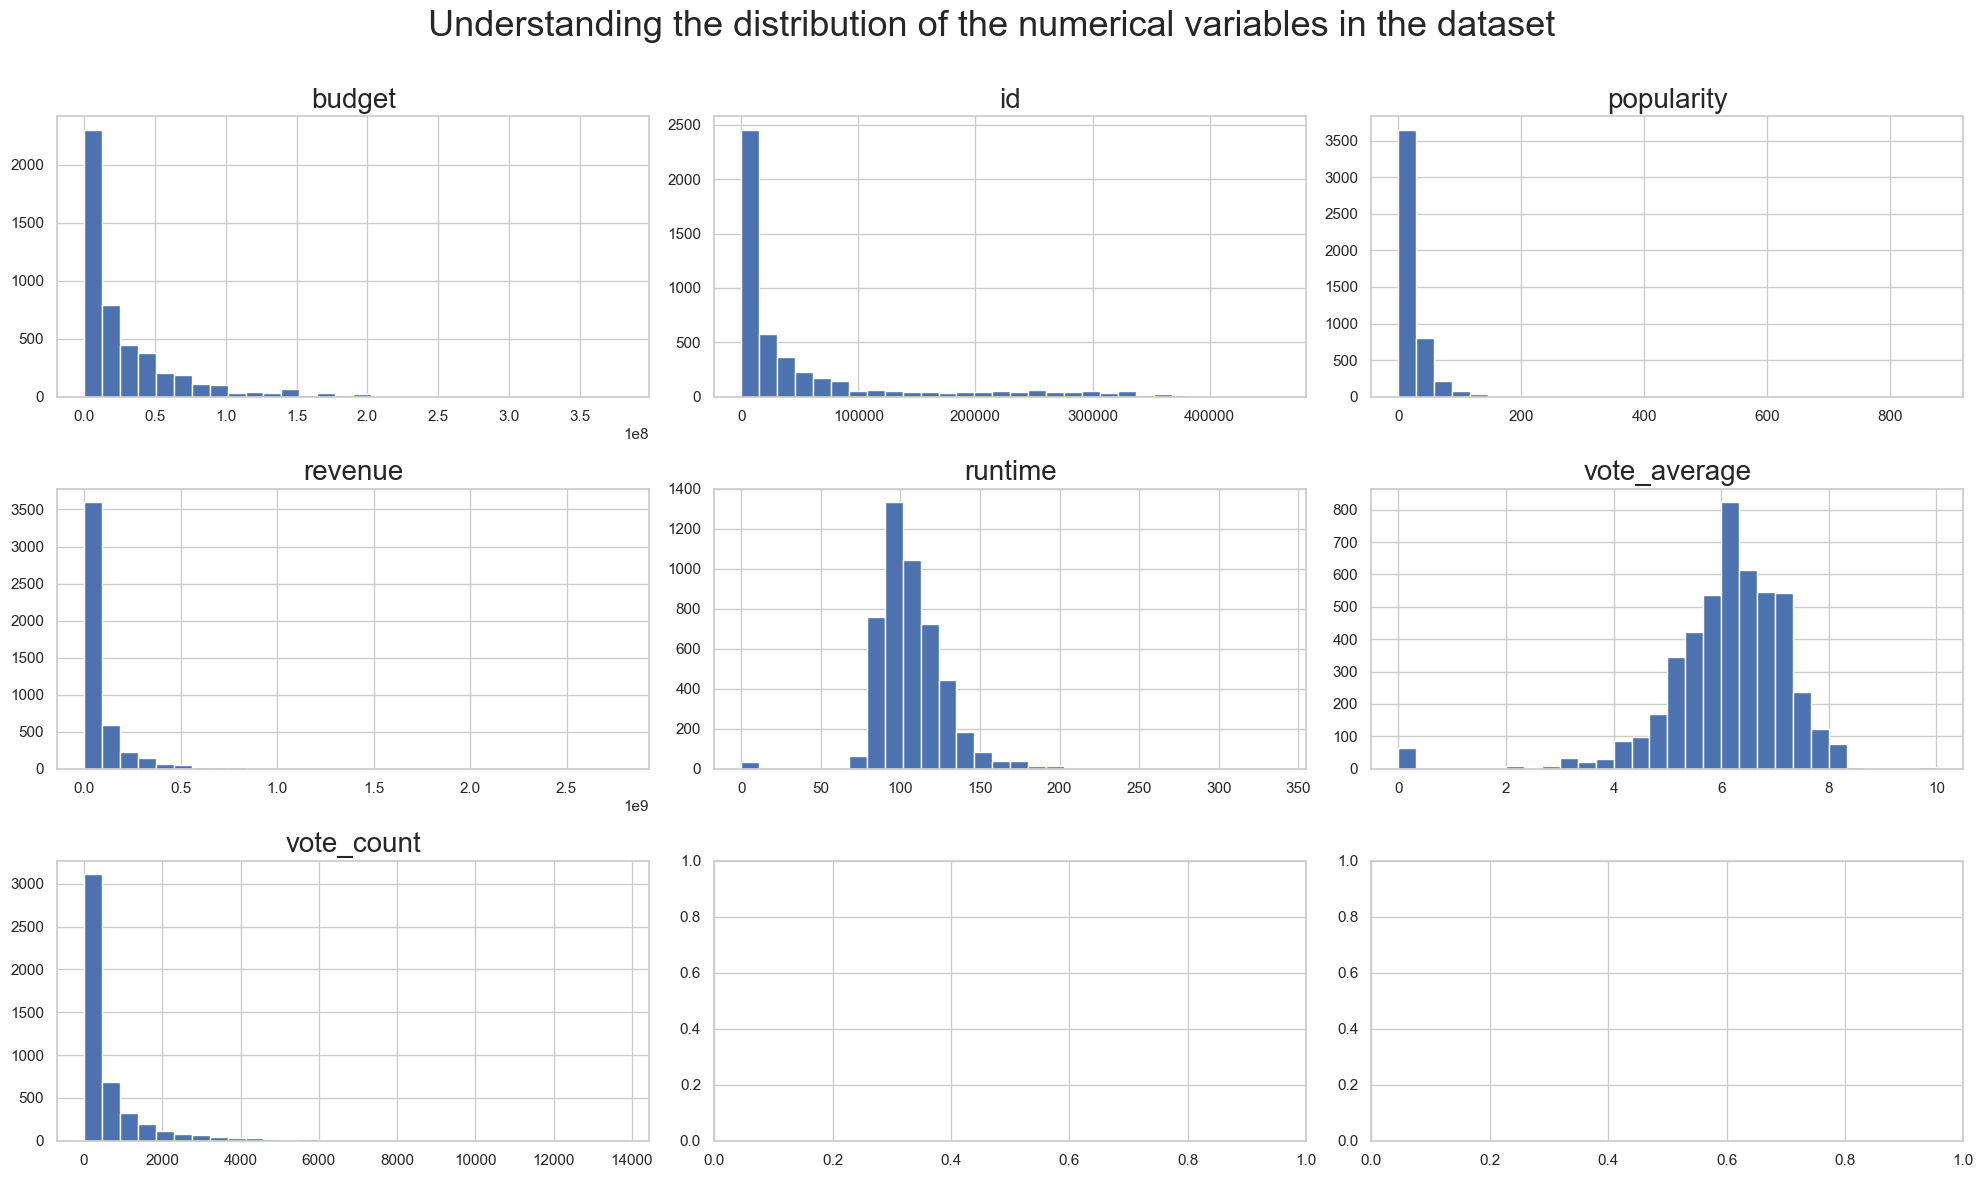

In [121]:
# Create subplots with a specific number of rows and columns
fig, axes = plt.subplots(3, 3, figsize=(20, 12)) 
# Select numeric columns
columns = movies_df.select_dtypes(include=['number']).columns  

# Iterate over numeric columns and plot on each subplot
for col, ax in zip(columns, axes.ravel()):  
    movies_df[col].hist(bins=30, ax=ax)
    ax.set_title(col,fontsize=20)

# Adjust layout and add a super title
plt.tight_layout(rect=[0, 0, 1, 0.93]) 
plt.suptitle('Understanding the distribution of the numerical variables in the dataset', fontsize=26)
plt.show()


# 5. Analyzing Data Distribution of Budget and Revenue
Analyzing the budget and revenue distribution in a movie dataset helps uncover trends, identify outliers (e.g., blockbuster hits or flops), and understand the financial dynamics of the industry for better insights.

In this part we create a function to analyze the distribution and behavior of a specific variable of the dataset.

In [122]:
sns.set(style='whitegrid')

def distribution_analysis(df,column_name):
    # Get the figure and axes objects for subplots
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    fig.suptitle('Distribution Analysis of ' + column_name, fontsize=16)

    # Histogram
    axes[0, 0].hist(df[column_name], bins=50, edgecolor='black')
    axes[0, 0].set_xlabel('Values')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Histogram')

    # Box Plot
    sns.boxplot(x=df[column_name], ax=axes[0, 1])
    axes[0, 1].set_xlabel('Values')
    axes[0, 1].set_title('Box Plot')

    # KDE Plot
    sns.kdeplot(df[column_name], fill=True, ax=axes[1, 0])
    axes[1, 0].set_xlabel('Values')
    axes[1, 0].set_ylabel('Density')
    axes[1, 0].set_title('KDE Plot')

    # QQ Plot
    stats.probplot(df[column_name], dist="expon", plot=axes[1, 1])
    axes[1, 1].set_title('QQ Plot')

    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)

    # Show the plots
    plt.show()

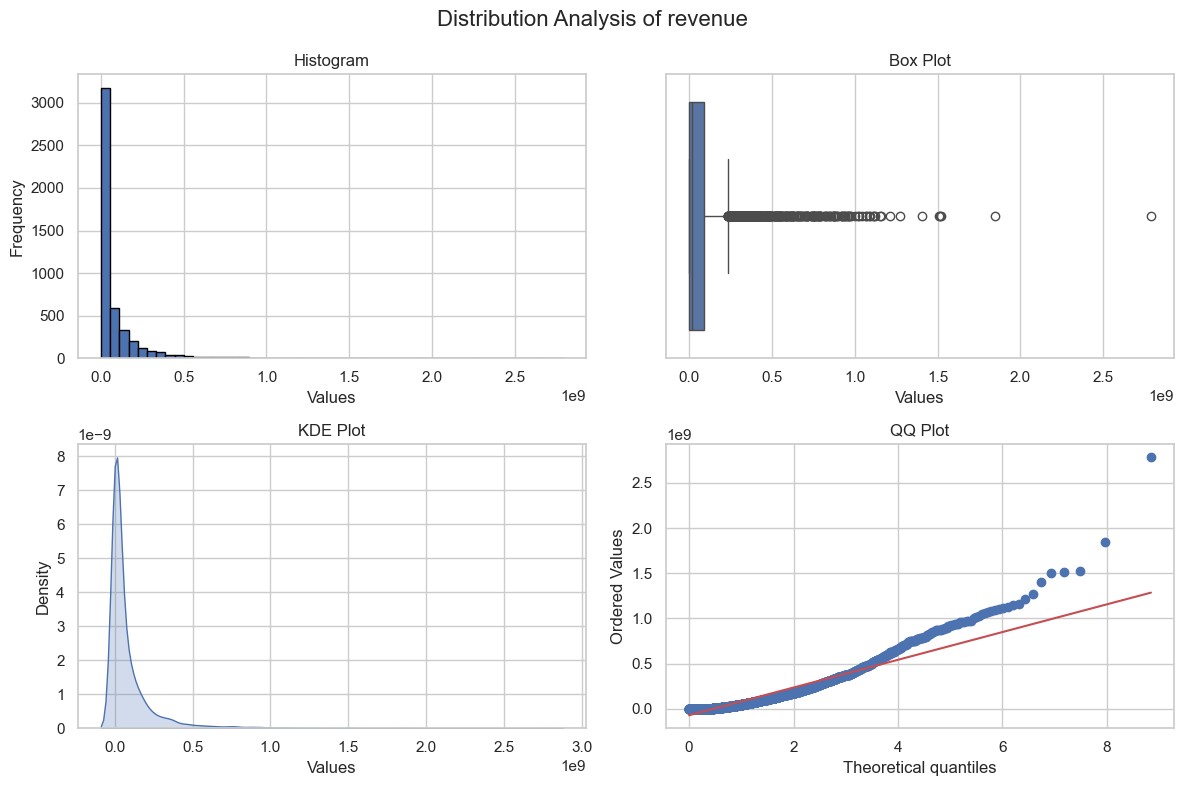

In [123]:
distribution_analysis(movies_df,'revenue')

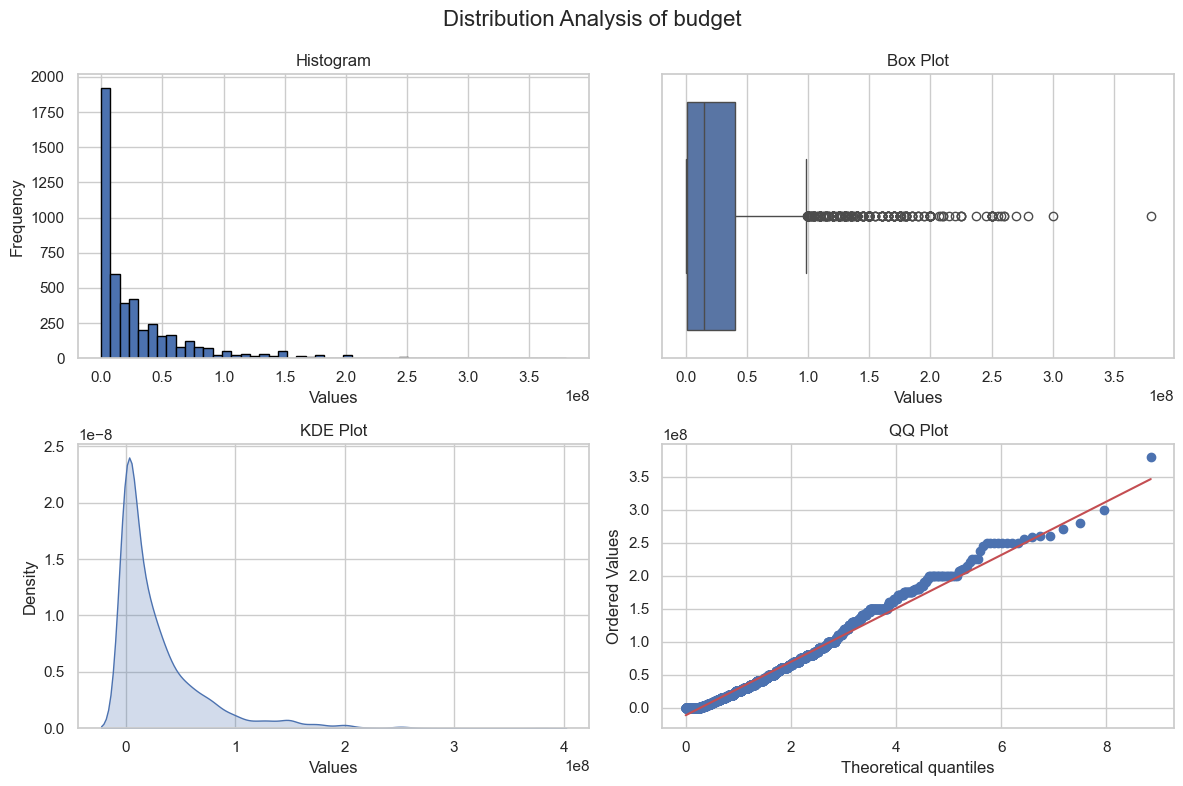

In [124]:
distribution_analysis(movies_df,'budget')

## Key Observations based on the plots
* __Budget__: A budget of 0 typically indicates missing or incorrect data. Therefore, budget values should ideally be greater than 0.
* __Revenue__: Similarly, a revenue of 0 is likely unrealistic, as movies generally generate at least some income if they have been distributed.

# 6. Data Preprocessing


Based on the distribution analysis of budget and revenue, we identified an unusual pattern with a bias near zero, indicating potential incorrect data. To address this, we will apply the interquartile range (IQR) technique combined with a minimum threshold to handle the anomalies effectively.

In [125]:
# Convert 'budget' and 'revenue' to numeric
movies_df['budget'] = pd.to_numeric(movies_df['budget'], errors='coerce')
movies_df['revenue'] = pd.to_numeric(movies_df['revenue'], errors='coerce')

# Minimum thresholds defined
min_budget_threshold = 50000   # Reasonable minimum budget
min_revenue_threshold = 1000   # Reasonable minimum revenue

# Calculate Q1, Q3, and IQR for budget
q1_budget = movies_df['budget'].quantile(0.25)
q3_budget = movies_df['budget'].quantile(0.75)
iqr_budget = q3_budget - q1_budget

# Calculate limits for budget
lower_limit_budget = max(q1_budget - 1.5 * iqr_budget, min_budget_threshold)
upper_limit_budget = q3_budget + 1.5 * iqr_budget

# Calculate Q1, Q3, and IQR for revenue
q1_revenue = movies_df['revenue'].quantile(0.25)
q3_revenue = movies_df['revenue'].quantile(0.75)
iqr_revenue = q3_revenue - q1_revenue

# Calculate limits for revenue
lower_limit_revenue = max(q1_revenue - 1.5 * iqr_revenue, min_revenue_threshold)
upper_limit_revenue = q3_revenue + 1.5 * iqr_revenue

# Filter the dataset by both criteria
filtered_df = movies_df[
    (movies_df['budget'] >= lower_limit_budget) & (movies_df['budget'] <= upper_limit_budget) &
    (movies_df['revenue'] >= lower_limit_revenue) & (movies_df['revenue'] <= upper_limit_revenue)
]

# Final information
print(f"Total data before filtering: {movies_df.shape[0]}")
print(f"Total data after filtering: {filtered_df.shape[0]}")


Total data before filtering: 4803
Total data after filtering: 2656


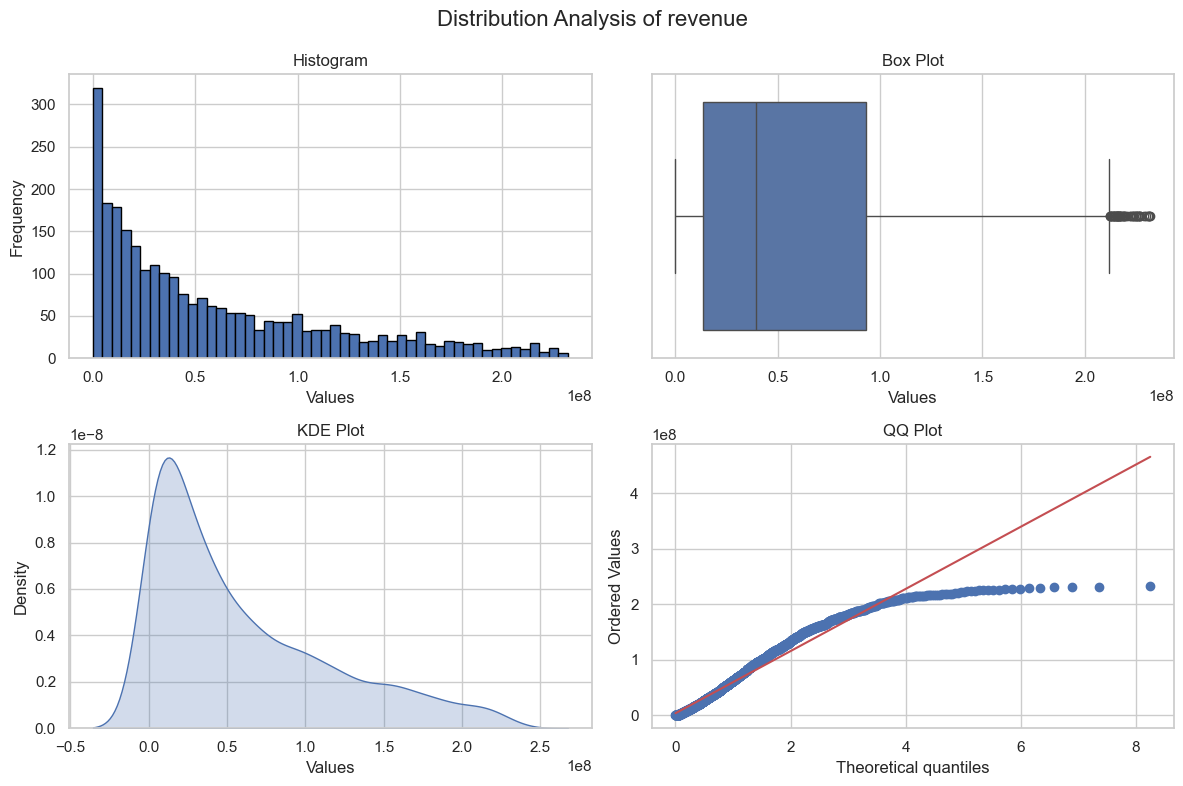

In [126]:
distribution_analysis(filtered_df,'revenue')

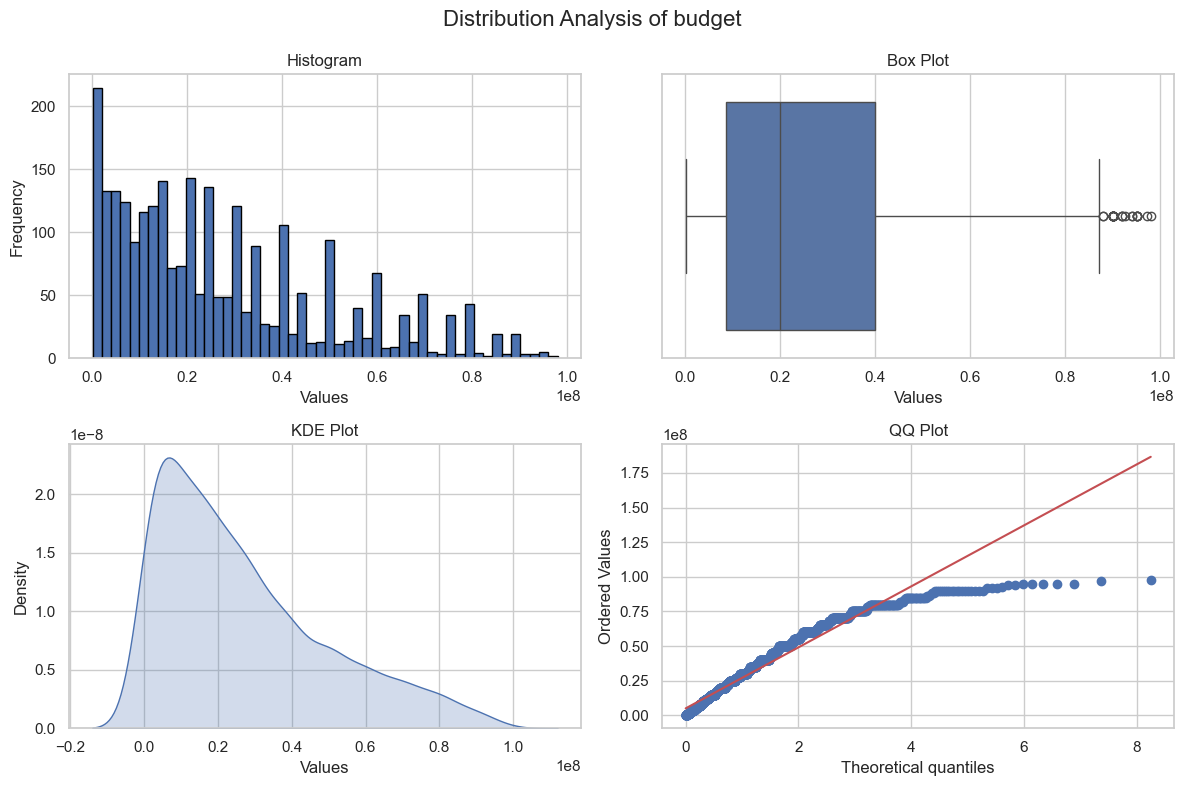

In [127]:
distribution_analysis(filtered_df,'budget')

# 7. EDA (Exploratory Data Analysis)
Exploratory Data Analysis involves examining the dataset to uncover patterns, detect anomalies, and gain insights into the structure and relationships within the data, laying the foundation for informed decision-making in the analysis process.

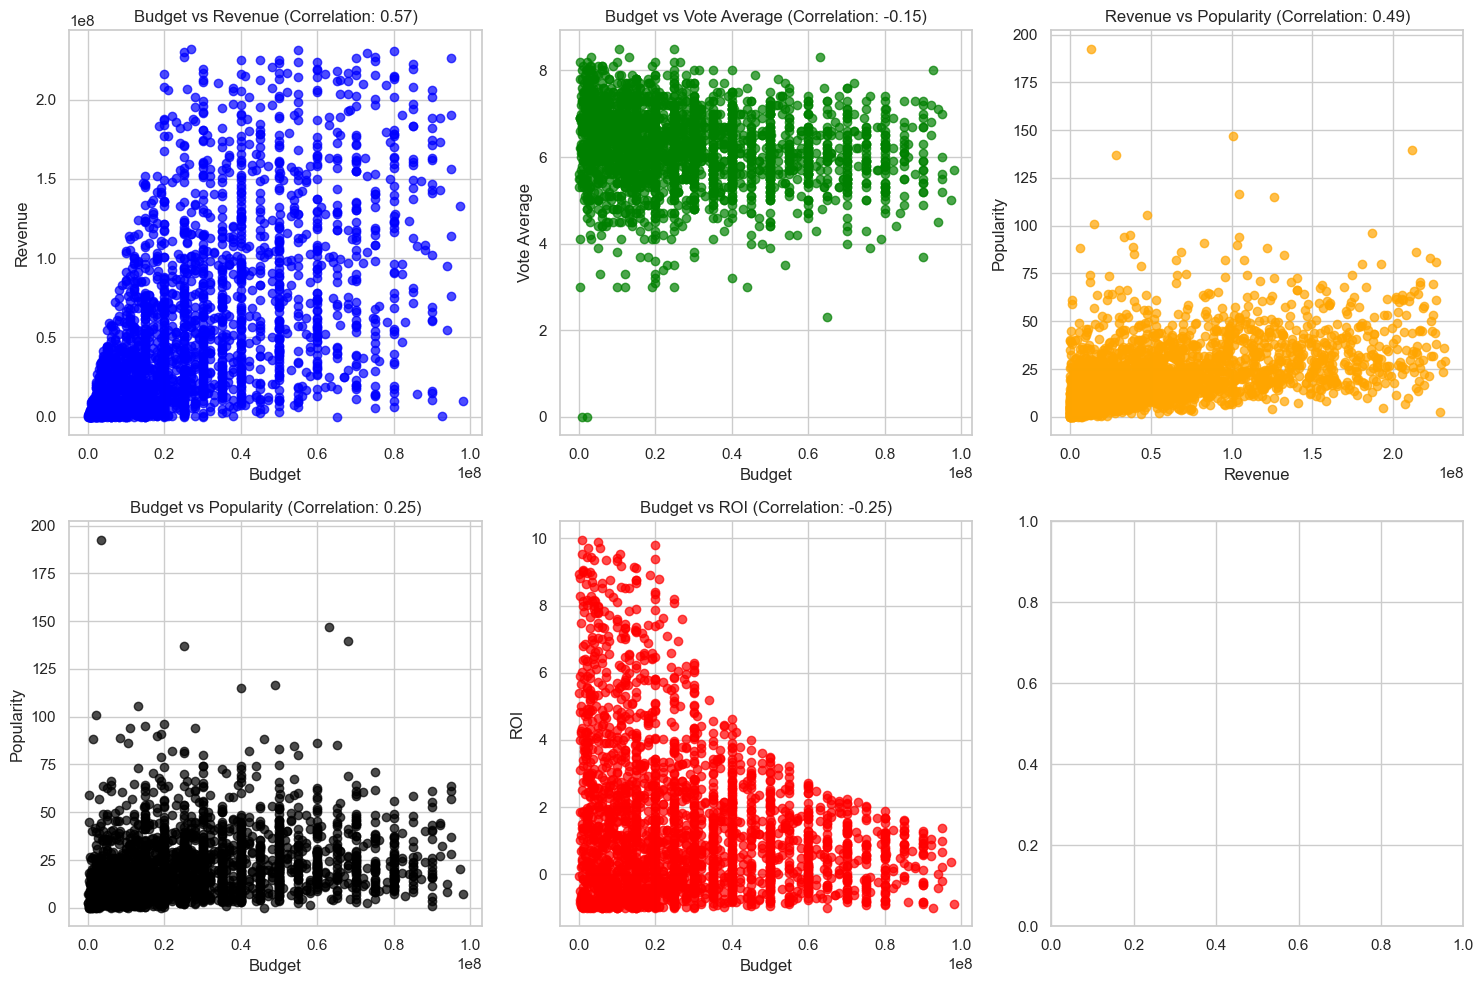

In [116]:
# Calculate ROI and filter out extreme values
filtered_df = filtered_df.copy()
filtered_df['ROI'] = (filtered_df['revenue'] - filtered_df['budget']) / filtered_df['budget']
df_filtered = filtered_df[(filtered_df['ROI'] > -10) & (filtered_df['ROI'] < 10)]

# Calculate correlations in the filtered DataFrame
correlation_budget_revenue = df_filtered['budget'].corr(df_filtered['revenue'])
correlation_budget_vote = df_filtered['budget'].corr(df_filtered['vote_average'])
correlation_budget_popularity = df_filtered['budget'].corr(df_filtered['popularity'])
correlation_revenue_popularity = df_filtered['revenue'].corr(df_filtered['popularity'])
correlation_budget_roi = df_filtered['budget'].corr(df_filtered['ROI'])

# Create subplots with correlations in the titles
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Budget vs Revenue
axs[0, 0].scatter(df_filtered['budget'], df_filtered['revenue'], alpha=0.7, color='blue')
axs[0, 0].set_title(f'Budget vs Revenue (Correlation: {correlation_budget_revenue:.2f})')
axs[0, 0].set_xlabel('Budget')
axs[0, 0].set_ylabel('Revenue')

# Budget vs Vote Average
axs[0, 1].scatter(df_filtered['budget'], df_filtered['vote_average'], alpha=0.7, color='green')
axs[0, 1].set_title(f'Budget vs Vote Average (Correlation: {correlation_budget_vote:.2f})')
axs[0, 1].set_xlabel('Budget')
axs[0, 1].set_ylabel('Vote Average')

# Revenue vs Popularity
axs[0, 2].scatter(df_filtered['revenue'], df_filtered['popularity'], alpha=0.7, color='orange')
axs[0, 2].set_title(f'Revenue vs Popularity (Correlation: {correlation_revenue_popularity:.2f})')
axs[0, 2].set_xlabel('Revenue')
axs[0, 2].set_ylabel('Popularity')

# Budget vs Popularity
axs[1, 0].scatter(df_filtered['budget'], df_filtered['popularity'], alpha=0.7, color='black')
axs[1, 0].set_title(f'Budget vs Popularity (Correlation: {correlation_budget_popularity:.2f})')
axs[1, 0].set_xlabel('Budget')
axs[1, 0].set_ylabel('Popularity')

# Budget vs ROI
axs[1, 1].scatter(df_filtered['budget'], df_filtered['ROI'], alpha=0.7, color='red')
axs[1, 1].set_title(f'Budget vs ROI (Correlation: {correlation_budget_roi:.2f})')
axs[1, 1].set_xlabel('Budget')
axs[1, 1].set_ylabel('ROI')

# Adjust layout
plt.tight_layout()
plt.show()


## Resume of correlation analysis

### Budget vs Revenue (Correlation: 0.57): 
* There is a moderate positive correlation between budget and revenue, suggesting that movies with higher budgets tend to generate higher revenues. However, this relationship is not strongly linear, indicating other factors beyond budget significantly influence revenue.

### Budget vs Vote Average (Correlation: -0.15):
* A weak negative correlation exists between budget and vote average, implying that higher-budget movies are slightly less likely to have higher vote averages. This suggests that large budgets do not necessarily equate to better critical reception or audience ratings.

### Revenue vs Popularity (Correlation: 0.49):
* A moderate positive correlation is observed between revenue and popularity, indicating that movies generating higher revenues are often more popular among audiences. This relationship likely reflects a reinforcing cycle where popular films attract larger audiences, boosting revenue, and higher revenue allows for broader distribution and marketing, further driving popularity.

### Budget vs Popularity (Correlation: 0.25):
* A weak positive correlation exists between budget and popularity, suggesting that movies with larger budgets tend to attract more attention and engagement from audiences. This may be due to higher spending on marketing and production quality, which can enhance a film's visibility and appeal, though the relationship is not strong.

### Budget vs ROI (Correlation: -0.25):
* The weak negative correlation between budget and ROI indicates that higher-budget movies often experience diminishing returns in profitability relative to their investment. This aligns with the notion that large budgets do not guarantee proportionally higher profits.


## Conclusion of correlation analysis
While larger budgets can increase a movie's revenue and popularity to some extent, they do not guarantee profitability (ROI) or audience approval (vote average). The moderate correlation between revenue and popularity highlights the interplay between financial success and audience engagement. However, the weak correlation between budget and popularity suggests that factors such as storytelling, cultural relevance, and strategic marketing may play a more significant role in driving audience interest than budget alone. This underscores the importance of balancing budgetary decisions with creative and strategic efforts to achieve holistic success in the film industry.

## Identifying the most profitable genres
This step focuses on analyzing revenue and budget data to determine which movie genres generate the highest profits, providing insights into industry trends and financial performance.

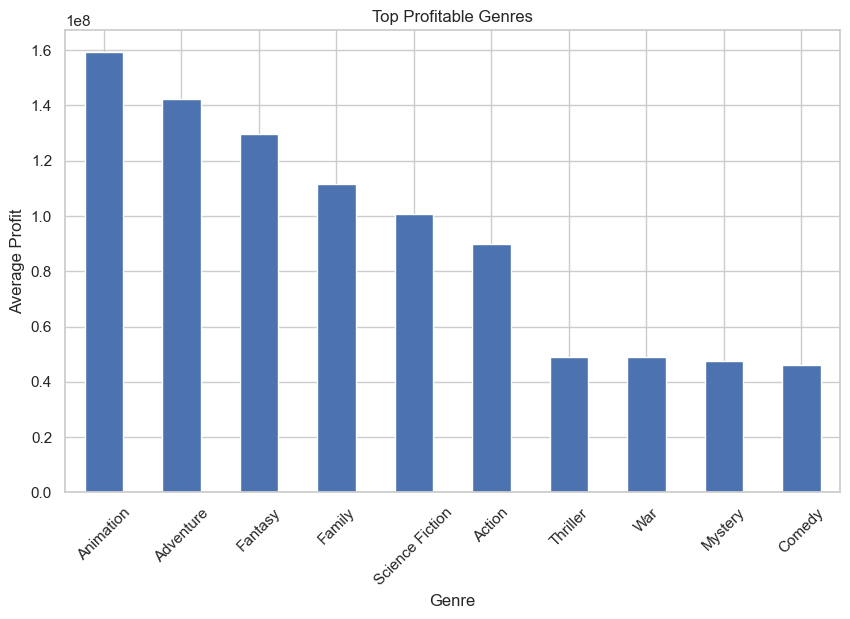

In [ ]:
# Parse the genres column to extract individual genres
def extract_genres(genre_list_str):
    try:
        genre_list = ast.literal_eval(genre_list_str)
        return [genre['name'] for genre in genre_list]
    except (ValueError, SyntaxError):
        return []

movies_df['Parsed_Genres'] = movies_df['genres'].apply(extract_genres)

# Calculate Profit
movies_df['Profit'] = movies_df['revenue'] - movies_df['budget']

# Analyze profitability by genres
genre_exploded = movies_df.explode('Parsed_Genres')  # Expand genres into individual rows
genre_profitability = (
    genre_exploded.groupby('Parsed_Genres')['Profit']
    .mean()
    .sort_values(ascending=False)
)

# Visualizations
# Top Profitable Genres
plt.figure(figsize=(10, 6))
genre_profitability.head(10).plot(kind='bar')
plt.title('Top Profitable Genres')
plt.xlabel('Genre')
plt.ylabel('Average Profit')
plt.xticks(rotation=45)
plt.show()


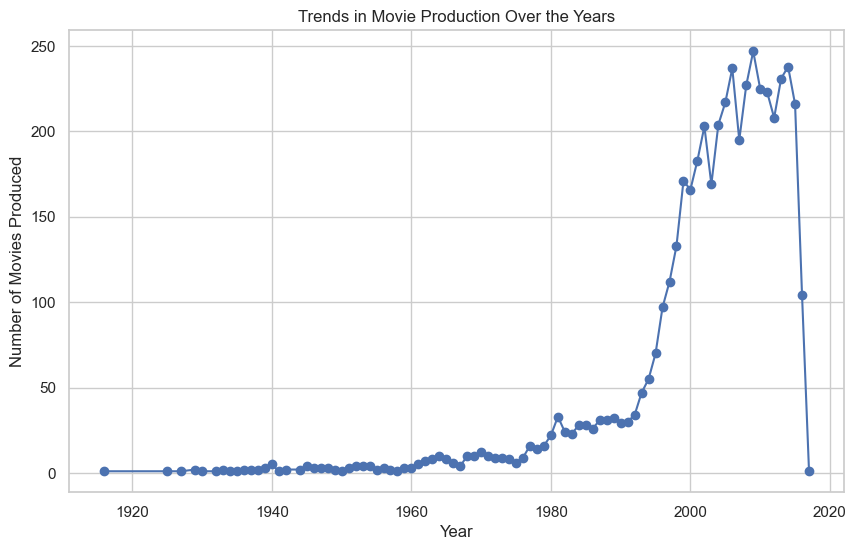

In [ ]:
# Analyze trends in movie production
movies_df['Release_Year'] = pd.to_datetime(movies_df['release_date'], errors='coerce').dt.year
production_trends = movies_df.groupby('Release_Year').size()

# Trends in Movie Production
plt.figure(figsize=(10, 6))
production_trends.plot(kind='line', marker='o')
plt.title('Trends in Movie Production Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Movies Produced')
plt.grid(True)
plt.show()

## Top Profitable Genres

* Certain genres consistently generate higher profits, such as Animation, Adventure, Fantasy, Family, Science Fiction. These genres likely appeal to a broader audience or align well with high-budget, high-revenue blockbusters.
* The presence of multiple profitable genres suggests that diverse storytelling can be financially successful when executed well.
* Genres with lower average profits may either represent niche markets or suffer from lower budget allocations and limited audience reach.

## Trends in Movie Production Over the Years

* There is a noticeable trend in movie production, with a significant increase observed in certain years. Peaks in production might correlate with industry booms, technological advancements, or shifts in audience demand.
* Consistent growth over time reflects the expansion of the film industry and increased accessibility to production resources.


# 8. Analyzing the provit over the years for selected

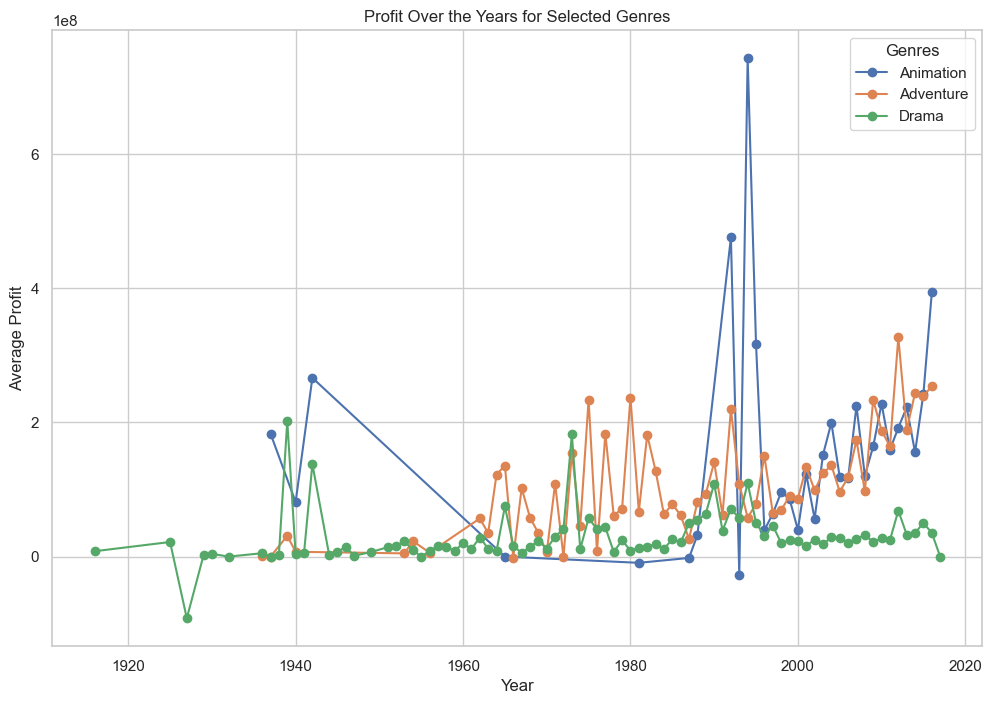

In [130]:
# List of genres to plot
selected_genres = ['Animation','Adventure','Drama']  # Replace with desired genres

# Ensure 'Release_Year' is included in the genre_exploded DataFrame
genre_exploded['Release_Year'] = pd.to_datetime(genre_exploded['release_date'], errors='coerce').dt.year

# Initialize a plot
plt.figure(figsize=(12, 8))

# Iterate through the selected genres
for genre in selected_genres:
    # Filter the dataset for the current genre
    genre_data = genre_exploded[genre_exploded['Parsed_Genres'] == genre]

    # Calculate average profit for the current genre over the years
    profit_over_years = (
        genre_data.groupby('Release_Year')['Profit']
        .mean()
        .dropna()
    )

    # Plot profit over the years for the current genre
    plt.plot(profit_over_years, marker='o', label=f'{genre}')

# Add plot details
plt.title('Profit Over the Years for Selected Genres')
plt.xlabel('Year')
plt.ylabel('Average Profit')
plt.grid(True)
plt.legend(title='Genres')
plt.show()


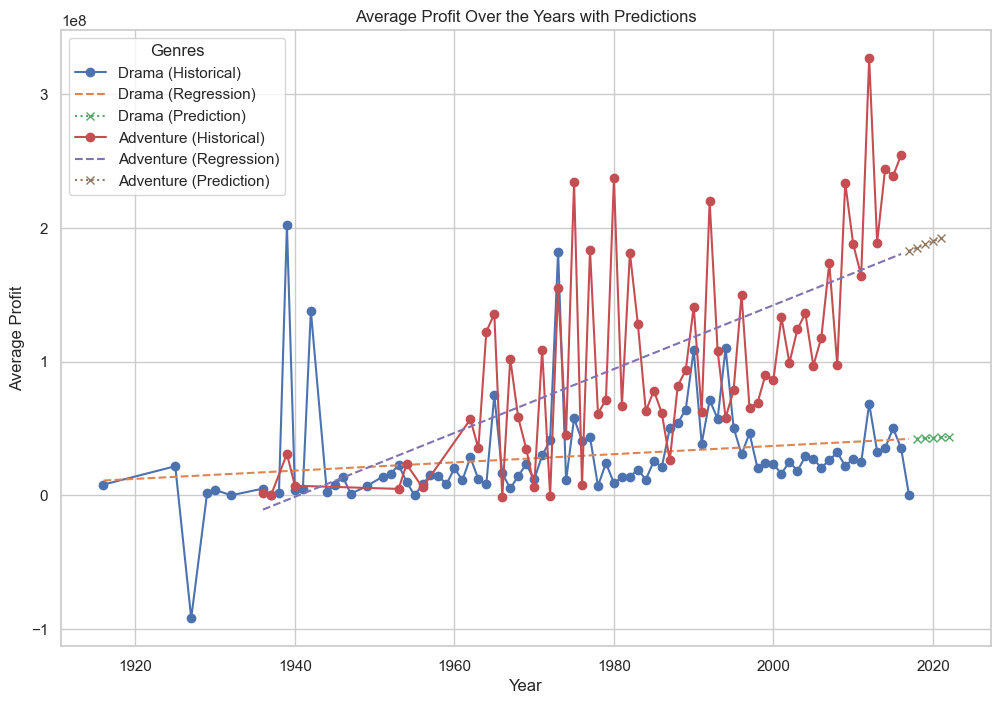

In [131]:
# List of genres to analyze
selected_genres = ['Drama','Adventure']  # Replace with desired genres

# Ensure 'Release_Year' is included in the genre_exploded DataFrame
genre_exploded['Release_Year'] = pd.to_datetime(genre_exploded['release_date'], errors='coerce').dt.year

# Initialize a plot
plt.figure(figsize=(12, 8))

# Iterate through the selected genres
for genre in selected_genres:
    # Filter the dataset for the current genre
    genre_data = genre_exploded[genre_exploded['Parsed_Genres'] == genre]

    # Calculate average profit for the current genre over the years
    profit_over_years = (
        genre_data.groupby('Release_Year')['Profit']
        .mean()
        .dropna()
    )

    # Prepare data for linear regression
    X = profit_over_years.index.values.reshape(-1, 1)  # Years as independent variable
    y = profit_over_years.values  # Average profit as dependent variable

    # Fit the linear regression model
    model = LinearRegression()
    model.fit(X, y)

    # Generate predictions for historical data
    y_pred = model.predict(X)

    # Predict the next five years
    future_years = np.arange(X.max() + 1, X.max() + 6).reshape(-1, 1)
    future_profits = model.predict(future_years)

    # Plot historical data
    plt.plot(profit_over_years.index, profit_over_years, marker='o', label=f'{genre} (Historical)')
    
    # Plot regression line
    plt.plot(profit_over_years.index, y_pred, linestyle='--', label=f'{genre} (Regression)')
    
    # Plot predictions for the next five years
    plt.plot(future_years, future_profits, linestyle=':', marker='x', label=f'{genre} (Prediction)')

# Add plot details
plt.title('Average Profit Over the Years with Predictions')
plt.xlabel('Year')
plt.ylabel('Average Profit')
plt.grid(True)
plt.legend(title='Genres')
plt.show()


In [113]:
# Calculate the overall average profit for each genre
average_profit_per_genre = (
    genre_exploded.groupby('Parsed_Genres')['Profit']
    .mean()
    .dropna()
    .sort_values(ascending=False)
)

# Top 5 genres with the highest average profit
top_5_genres = average_profit_per_genre.head(5)

# Bottom 5 genres with the lowest average profit
bottom_5_genres = average_profit_per_genre.tail(5)

# Display results
print("Top 5 Genres with Best Average Profit:")
print(top_5_genres)

print("\nBottom 5 Genres with Worst Average Profit:")
print(bottom_5_genres)



Top 5 Genres with Best Average Profit:
Parsed_Genres
Animation          1.592271e+08
Adventure          1.423333e+08
Fantasy            1.297936e+08
Family             1.116260e+08
Science Fiction    1.005910e+08
Name: Profit, dtype: float64

Bottom 5 Genres with Worst Average Profit:
Parsed_Genres
History        2.762010e+07
Western        1.916726e+07
Documentary    7.185600e+06
Foreign       -2.934369e+05
TV Movie      -1.150000e+06
Name: Profit, dtype: float64


## Conclusions: Profitability by Genre

### Top 5 Profitable Genres:
* The genres Animation, Adventure, and Fantasy lead in average profitability, with Animation topping the list at an impressive $159.2 million average profit. These genres often benefit from strong appeal across diverse age groups and global markets, particularly due to family-friendly content and significant merchandising opportunities.
* Genres like Family and Science Fiction also show high average profits, likely driven by their broad audience reach, international box office success, and potential for franchising.

### Bottom 5 Least Profitable Genres:
* At the lower end, History, Western, and Documentary films have significantly lower average profits, with documentaries often being niche-focused and lacking wide audience appeal or marketing budgets.
The Foreign and TV Movie genres show negative or minimal profitability, which could reflect limited distribution, lower budgets, and constrained marketing efforts compared to mainstream genres.

### Key Insights:
* Genres with high visual appeal, global relatability, and opportunities for cross-platform monetization tend to dominate in profitability. This aligns with the increasing preference for large-scale, visually engaging content in global cinema.
* Conversely, genres like Documentary, History, and Western often cater to niche audiences, resulting in lower average profits. These genres may require targeted marketing strategies or reduced budget models to optimize their financial outcomes.

### Implications:
* Investments in top-performing genres like Animation, Adventure, and Fantasy are more likely to yield significant financial returns, especially when accompanied by effective global marketing and merchandising.
* For less profitable genres, producers and investors may consider alternate distribution strategies (e.g., streaming platforms) or focusing on awards-driven narratives to improve profitability and visibility.